In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/sample_submission.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv
/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [4]:
train_df = pd.read_csv('/kaggle/input/dry-beans-classification-iti-ai-pro-intake01/train.csv')

In [5]:
X = train_df.drop(columns=['ID','y'])
y = train_df.y

In [6]:
data = ['Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4']

pt = PowerTransformer()

pt.fit(X[data])

transformed_data = pt.transform(X[data])

X[data] = transformed_data

X['Area'] = np.log10(X.Area)
area_mean, area_std = X.Area.mean(), X.Area.std()
X['Area'] =( X.Area - area_mean) / area_std

X['ConvexArea'] = np.log10(X.ConvexArea)
convex_area_mean, convex_area_std = X.ConvexArea.mean(), X.ConvexArea.std()
X['ConvexArea'] =( X.ConvexArea - convex_area_mean) / convex_area_std

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [7]:
def plot_heat_map(df):
    plt.figure(figsize=(16, 6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

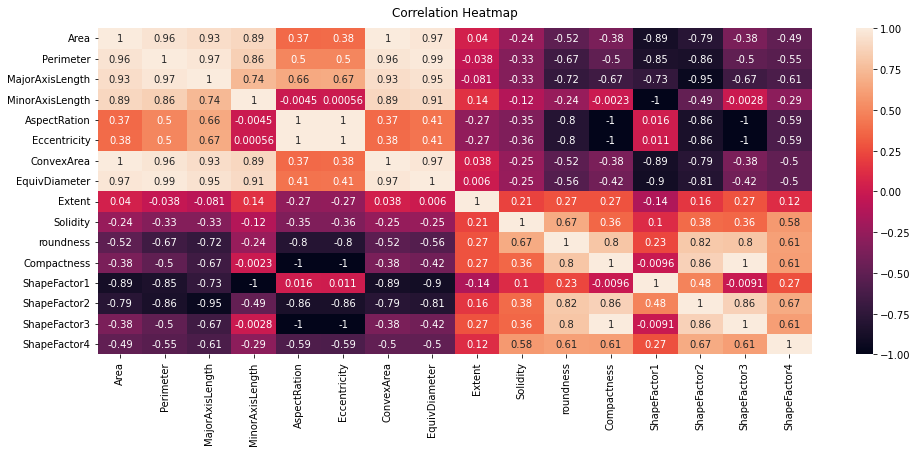

In [8]:
plot_heat_map(X)

In [9]:
X_final = X.drop(columns=['ConvexArea', 'Eccentricity', 'Compactness', 'ShapeFactor3', 'Perimeter',
             'Area', 'EquivDiameter', 'ShapeFactor1', 'ShapeFactor2'])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, stratify = y, random_state = 42)

In [11]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [12]:
y_train = le.transform(y_train)
y_val = le.transform(y_val)

In [13]:
def plot_confusion_matrix(clf, true_values, predicted_values):
    plt.figure(figsize = (8, 7))
    sns.heatmap(confusion_matrix(true_values, predicted_values),
                annot = True,
                fmt = ".0f",
                cmap = "coolwarm",
                linewidths = 2, 
                linecolor = "white",
                xticklabels = le.inverse_transform(clf.classes_),
                yticklabels = le.inverse_transform(clf.classes_))
    
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Confusion matrix on the testing data")
    plt.show()

LGBM Classifier:
Training Accuracy: 0.967


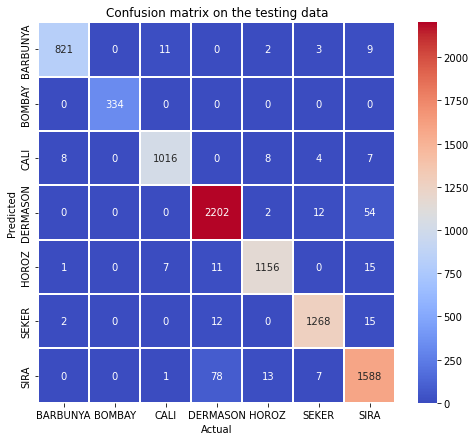

Validation Classifier: 0.936


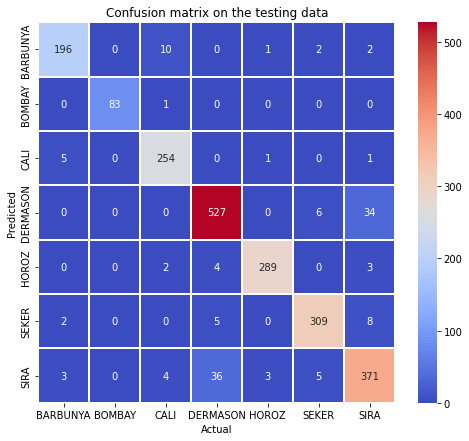

In [14]:
parameter = {'n_estimators': 50,
             'random_state': 42,
             'reg_lambda': 6,
             'reg_alpha': 1
             }

clf = LGBMClassifier(**parameter)  
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print('LGBM Classifier:\nTraining Accuracy: {:.3f}'.format(accuracy))
plot_confusion_matrix(clf, y_train, y_pred)


y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Validation Classifier: {:.3f}'.format(accuracy))
plot_confusion_matrix(clf, y_val, y_pred)

Voting Classifier:
Training Accuracy: 0.943
Validation Classifier: 0.934


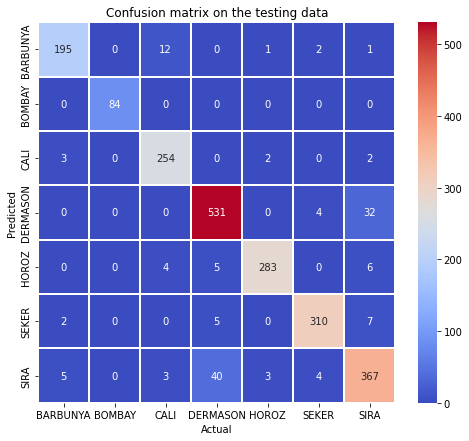

****************************************************************
Voting Classifier:
Training Accuracy: 0.948
Validation Classifier: 0.934


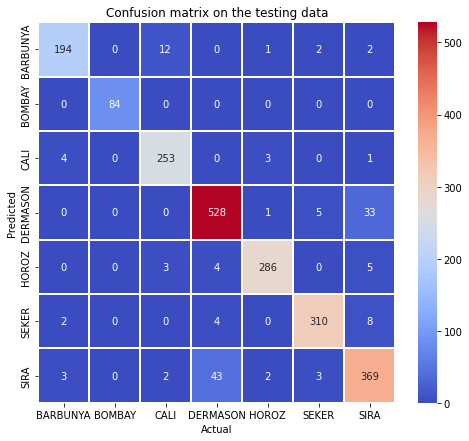

****************************************************************
Voting Classifier:
Training Accuracy: 0.924
Validation Classifier: 0.923


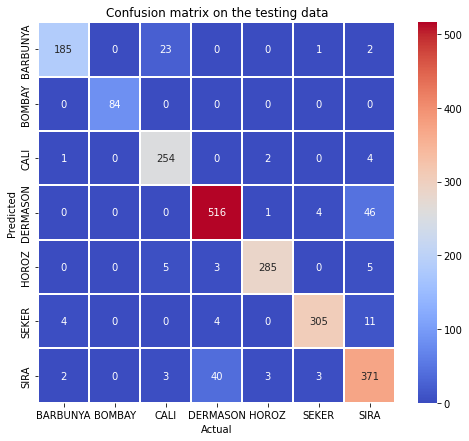

****************************************************************
Voting Classifier:
Training Accuracy: 0.957
Validation Classifier: 0.936


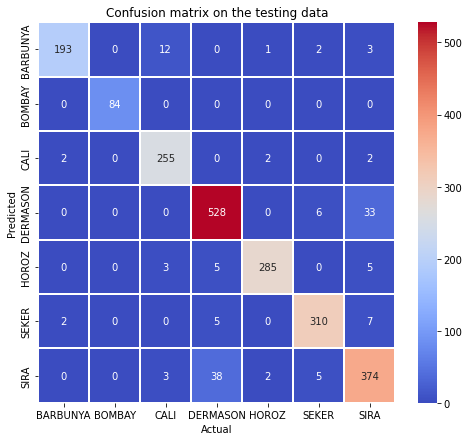

****************************************************************
Voting Classifier:
Training Accuracy: 0.967
Validation Classifier: 0.936


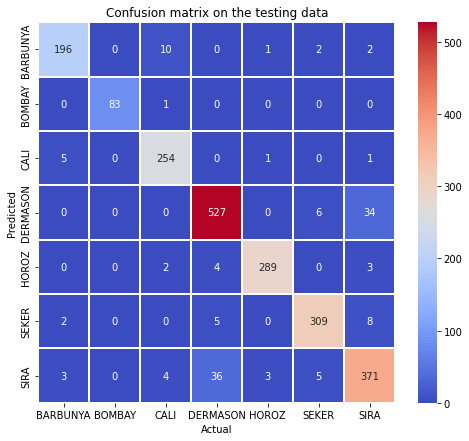

****************************************************************
Voting Classifier:
Training Accuracy: 0.952
Validation Classifier: 0.938


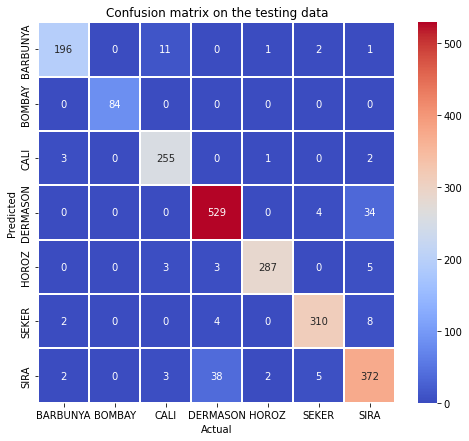

In [15]:
# Set seed for reproducibility
SEED=42

# Instantiate mlp
mlp = MLPClassifier(random_state=SEED, max_iter=500)

# Instantiate svm
svc = SVC(random_state=SEED, gamma=0.55, C=2,decision_function_shape='ovo', probability=True)

# XGBOOST
xgb = XGBClassifier(max_depth=7, 
                    learning_rate=0.21, 
                    n_estimators=23, 
                    gamma=2.1,
                    verbosity=0,
                    random_state=SEED,
                    use_label_encoder=False
                   )

# LGBM
gb = LGBMClassifier(random_state=SEED, 
                     n_estimators=50, 
                     reg_lambda=6, 
                     reg_alpha=1)

# Instantiate knn
knn = KNN(n_neighbors=30)

# Define the list classifiers
classifiers = [('MLP Classifier', mlp), ('SVC', svc), ('K Nearest Neighbours', knn), ('XGboost', xgb), ('LGBM', gb)]

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:
 
    # Fit vc to the training set
    clf.fit(X_train, y_train) 
    
    # Calculate Training accuracy
    accuracy = accuracy_score(y_train, clf.predict(X_train))
    print('Voting Classifier:\nTraining Accuracy: {:.3f}'.format(accuracy))
    
    # Evaluate the test set predictions
    y_pred = clf.predict(X_val)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    print('Validation Classifier: {:.3f}'.format(accuracy))
    
    #Plot Confusion Matrix
    plot_confusion_matrix(clf, y_val, y_pred)
        
    print('****************************************************************')

# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)   

# Fit vc to the training set
vc.fit(X_train, y_train) 

# Calculate Training accuracy
accuracy = accuracy_score(y_train, vc.predict(X_train))
print('Voting Classifier:\nTraining Accuracy: {:.3f}'.format(accuracy))

# Evaluate the test set predictions
y_pred = vc.predict(X_val)

# Calculate accuracy score
accuracy = accuracy_score(y_val, y_pred)
print('Validation Classifier: {:.3f}'.format(accuracy))

#Plot Confusion Matrix
plot_confusion_matrix(vc, y_val, y_pred)